# Passing in the National Simulation Football League

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances_argmin

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
passDF = pd.read_csv('Stats/PassingDF.csv')
# passDF['nameSeason'] = passDF.apply(lambda p: '%s (S%i)'%(p['Name'],p['S']),axis = 1)
passDF = passDF.drop(['Unnamed: 0','Player'],axis=1)
passDF = passDF[passDF['Att'] > 50]
passDF.columns

Index(['teamID', 'ACC', 'AGI', 'ARM', 'Att', 'Comp', 'END', 'G', 'HND', 'INT', 'Int', 'KAc', 'KDi', 'L', 'Lg', 'Name', 'OVR', 'PA', 'PBl', 'PF', 'Pct', 'Pos', 'RBl', 'Rating', 'S', 'SPE', 'STR', 'T', 'TCK', 'TD', 'Team', 'W', 'WPct', 'Yards'], dtype='object')

In [3]:
len(passDF.columns)

34

I'm going to make a copy of only the statistics columns (so nothing about attributes or wins, just pure passing).

In [4]:
df = passDF[['Att','Comp','Int','Lg','Pct','Rating','TD','Yards']].copy()
# df = df.drop(['Name','S','Pos','Team','W','WPct','teamID','ACC','AGI','ARM','END','G','HND','INT','KAc','KDi','L','OVR','PA','PF','RBl','SPE','STR','T','TCK'],axis=1)
len(df.columns)

8

## K-Means Analysis

Much of this k-means code is copied directly from [here](https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2). Essentially we're looking for a drop-off point, which I take as 2 for no real good reason other than not having to change the code and generating the next graph.

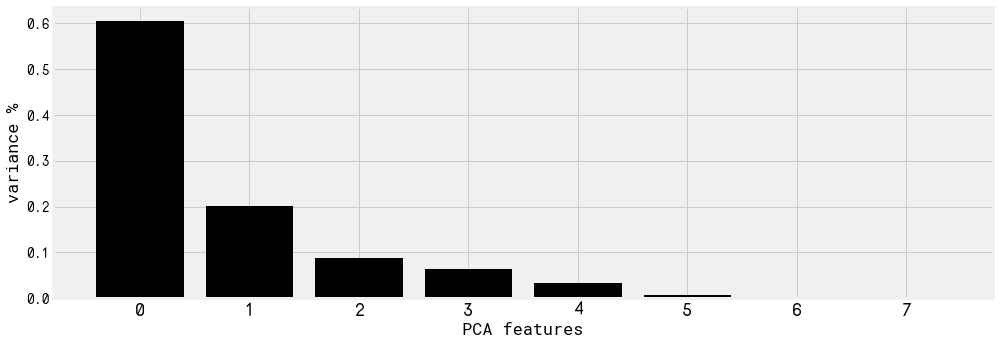

In [5]:
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=len(df.columns))
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,5),facecolor='w')
plt.rcParams['font.family'] = 'Roboto Mono'
plt.rcParams['font.weight'] = 'medium'
plt.xticks(fontname = 'NovaMono',weight='medium',size=18)
plt.yticks(fontname = 'NovaMono',weight='medium')
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

Plotting every quarterback's statistics w.r.t. each Principal Component:

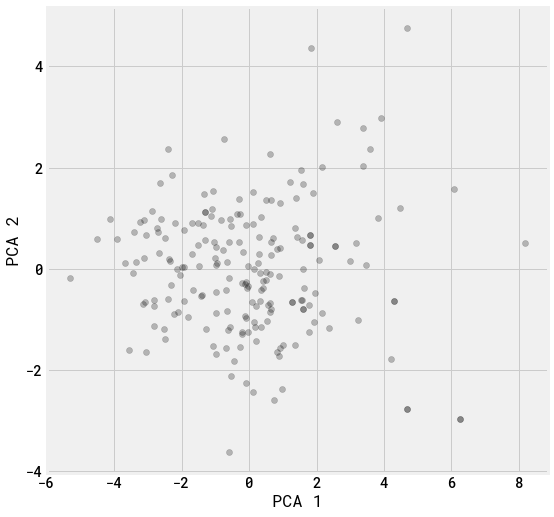

In [6]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
plt.figure(figsize=(8,8),facecolor='w')
plt.scatter(PCA_components[0], PCA_components[1], alpha=.25, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

What is the correct number of clusters to have? We're looking for an "elbow point" where the change in inertia starts to slow down. I go with `k=5` here.

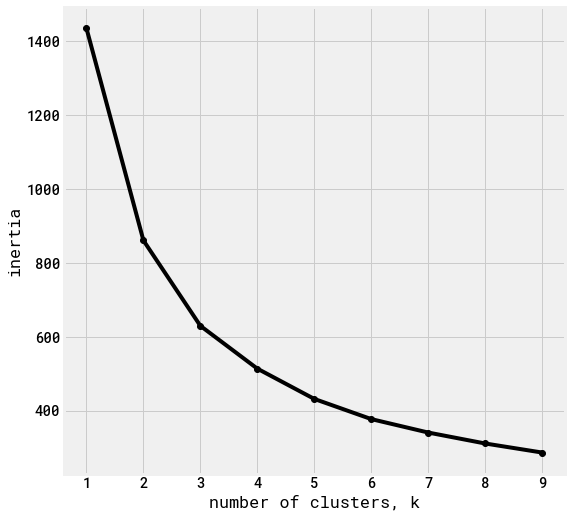

In [7]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,random_state=1)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.figure(figsize=(8,8),facecolor='w')
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

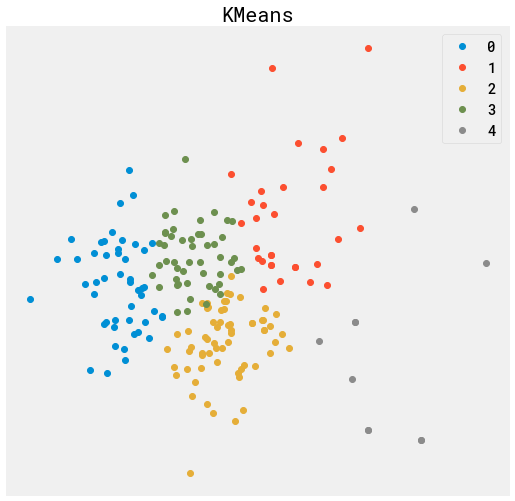

In [8]:
n_k = 5
model = KMeans(n_clusters = n_k,random_state=1)
X = PCA_components.iloc[:,:n_k-1]

model.fit(X)

model_centers = model.cluster_centers_

model_labels = pairwise_distances_argmin(X, model_centers)

model_labels

colors = ['C0','C1','C2','C3','C4','C5']

model_centers

len(model_labels)
# plt.style.use('default')
fig = plt.figure(figsize=(8, 8),facecolor='w')
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(n_k),colors):
    my_members = model_labels == k
    cluster_center = model_labels[k]
    ax.plot(X[my_members][0], X[my_members][1],
            markerfacecolor=col, marker='o',label=k,lw=0)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.legend()
plt.show()

passDF['k'] = model_labels

## Analyzing the Generated Clusters

In [9]:
pk_list = [passDF[passDF['k'] == i][['k','Att','Comp','Yards','TD','Int','Pct','Rating']].describe().loc['mean'] for i in range(n_k)]
print([(i, len(passDF[passDF['k'] == i])) for i in range(n_k)])
pd.concat(pk_list,axis=1).transpose().set_index('k').transpose()

[(0, 48), (1, 31), (2, 63), (3, 49), (4, 10)]


k,0.0,1.0,2.0,3.0,4.0
Att,608.333333,446.161290,450.063492,548.938776,229.60
Comp,360.562500,240.838710,258.317460,316.020408,118.90
Yards,4585.791667,2635.612903,3150.523810,3722.408163,1266.30
TD,33.020833,12.419355,19.539683,21.775510,4.80
Int,12.791667,18.677419,8.793651,14.938776,7.20
Pct,59.314583,54.048387,57.450794,57.618367,52.05
Rating,92.443750,63.509677,85.544444,80.271429,62.78


Looking at the averages, we can start to come to some conclusions.
* **Class 0** seems to be the cream of the crop QB in terms of rating and passing yards. Averaging a 33-12 TD-INT ratio and over 4500 passing yards, this is truly an **Air Raid QB**.
* **Class 2** is not far behind Class 0 in rating. They average significantly fewer yards but seem to be good at protecting the ball and not throwing interceptions. We can call them **Game Manager QBs**.
* **Class 3** is slightly behind Class 2 in rating, but throw for significantly more yards, as well as more TDs and INTs. I think it's fair to call them **Gunslinger QBs**.
* **Class 1** fall significantly behind the other 3 classes, with an average rating of 63.5. They throw for significantly less yards and touchdowns, and many more interceptions. These are **Sub-Par QBs**.
* **Class 4** have similar ratings to Class 1, but lag significantly behind in terms of bulk statistics. These are **Tank Commanders** or **Replacement QBs**.

In [10]:
def classLabel(k):
    if k == 0:
        return "Air Raid"
    elif k == 1:
        return "Sub-Par"
    elif k == 2:
        return "Game Manager"
    elif k == 3:
        return "Gunslinger"
    else:
        return "Replacement"

passDF['labelName'] = passDF.apply(lambda x: classLabel(x['k']),axis=1)

We can re-inforce these beliefs by looking at Yards and Passer Rating:

In [11]:
def pltK(stat):
    statList = passDF[stat]
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(20,8),facecolor='w')
    plt.rcParams['font.family'] = 'Roboto Mono'
    plt.rcParams['font.weight'] = 'medium'
    plt.xticks(fontname = 'NovaMono',weight='medium',size=18)
    plt.yticks(fontname = 'NovaMono',weight='medium')
    plt.title(stat,size=18)
    for i in range(n_k):
        plt.hist(passDF[passDF.k == i][stat],label=classLabel(i),histtype='step',lw=5,alpha=0.75)
    plt.legend(title='Class', title_fontsize=14, fontsize=14)
    plt.tight_layout()
    plt.savefig('passing/%s_stat.png'%stat,facecolor=fig.get_facecolor(),bbox_inches='tight')
    plt.show()

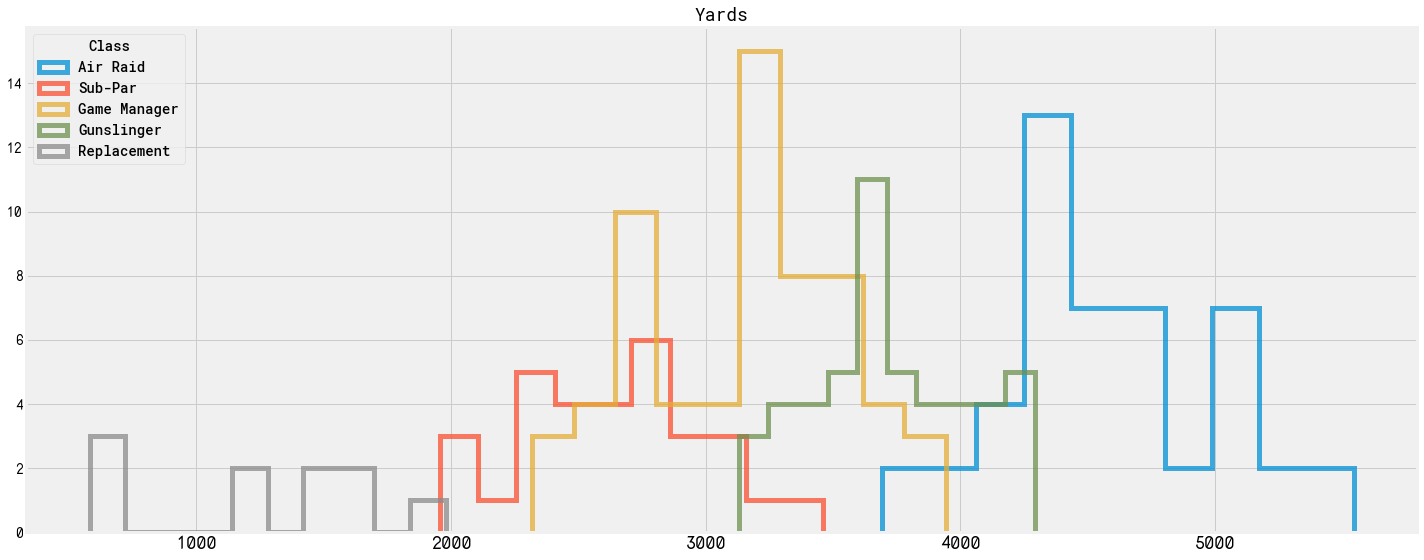

In [12]:
pltK('Yards')

This matches up so far. **Air Raid** QBs throw for by far the most yards, with **Gunslingers** not far behind. **Game Managers** fall slightly behind them, and the worse QBs trail off.

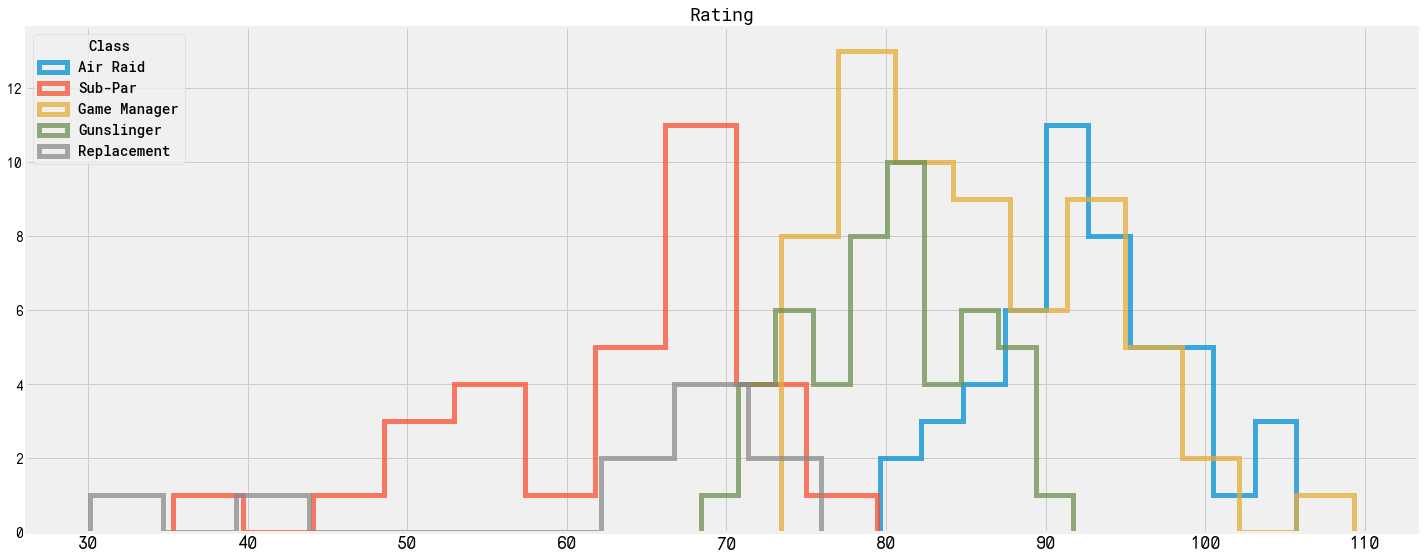

In [13]:
pltK('Rating')

Again, this matches our intuition. **Air Raid** and **Game Manager** QBs have the highest ratings, while we see the **Gunslinger** cluster at lower ratings.

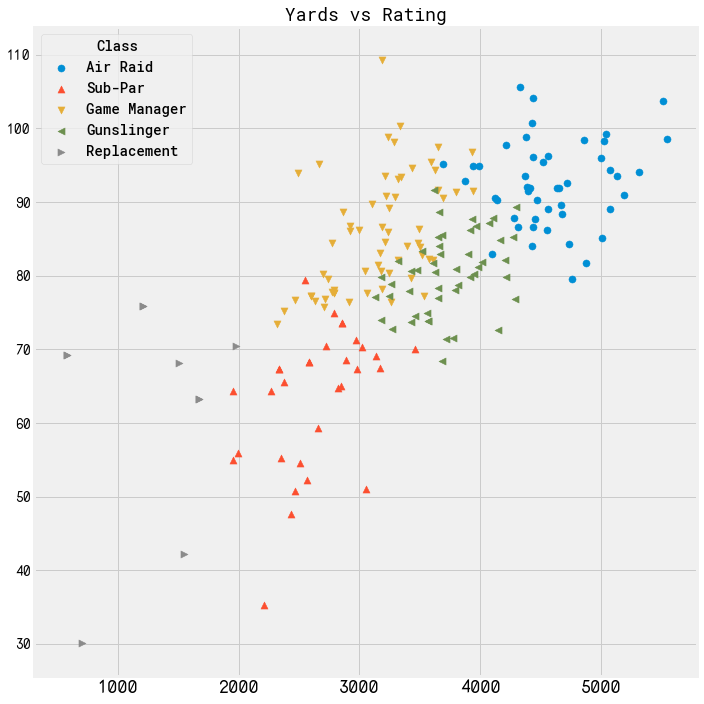

In [14]:
markerList = ['o','^','v','<','>']
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10),facecolor='w')
plt.rcParams['font.family'] = 'Roboto Mono'
plt.rcParams['font.weight'] = 'medium'
plt.xticks(fontname = 'NovaMono',weight='medium',size=18)
plt.yticks(fontname = 'NovaMono',weight='medium')
plt.title('Yards vs Rating',size=18)
for i in range(n_k):
    plt.scatter(passDF[passDF.k == i]['Yards'],passDF[passDF.k == i]['Rating'],label=classLabel(i),s=50,marker=markerList[i])
plt.legend(title='Class', title_fontsize=14, fontsize=14)
plt.tight_layout()
plt.savefig('passing/Yards_vs_Rating_stat.png',facecolor=fig.get_facecolor(),bbox_inches='tight')
plt.show()

Just as expected. These two stats must be significant to the calculations made by the K-Means clustering.

### Season by Season

So how has the meta evolved over time?

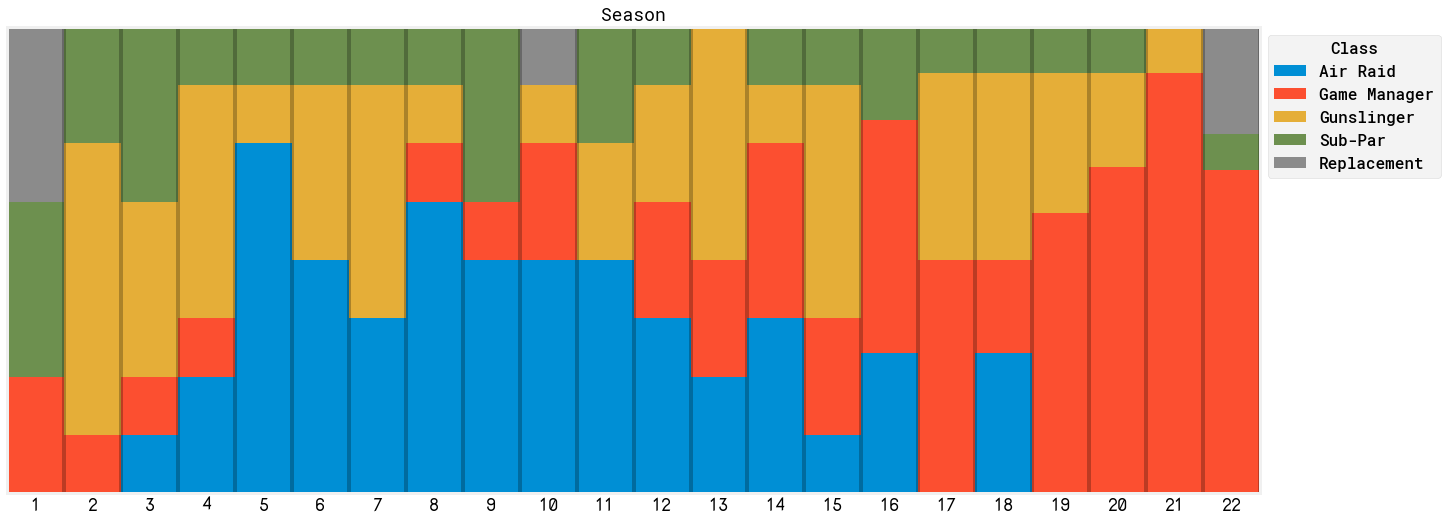

In [15]:
SArr = np.array([[len(passDF[(passDF.S == i) & (passDF.k == j)])/len(passDF[passDF.S == i]) for i in np.arange(1,23,1)] for j in range(6)])

bottom1 = np.add(SArr[0,:],SArr[2,:])
bottom2 = np.add(bottom1,SArr[3,:])
bottom3 = np.add(bottom2,SArr[1,:])
bottom4 = np.add(bottom3,SArr[4,:])
# bottom5 = np.add(bottom4,SArr[5,:])

xrange = np.arange(1,23,1)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,8),facecolor='w')
plt.rcParams['font.family'] = 'Roboto Mono'
plt.rcParams['font.weight'] = 'medium'
plt.xticks(fontname = 'NovaMono',weight='medium',size=18)
plt.yticks(fontname = 'NovaMono',weight='medium')
plt.title('Season',size=18)
plt.xlim(0.5,22.5)
plt.xticks(xrange)
plt.yticks(())
for x in xrange:
    plt.axvline(x+0.5,c='k',alpha=0.25)
plt.bar(xrange,SArr[0,:],width=1,label=classLabel(0))
plt.bar(xrange,SArr[2,:],bottom = SArr[0,:],width=1,label=classLabel(2))
plt.bar(xrange,SArr[3,:],bottom = bottom1,width=1,label=classLabel(3))
plt.bar(xrange,SArr[1,:],bottom = bottom2,width=1,label=classLabel(1))
plt.bar(xrange,SArr[4,:],bottom = bottom3,width=1,label=classLabel(4))
# plt.bar(xrange,SArr[5,:],bottom = bottom4,width=1,label=5)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, title='Class', title_fontsize=16, fontsize=16)
plt.savefig('passing/season.png')
plt.show()

Here, we see that there's a clear shift around S17 where **Game Manager** QBs become much more prevalent. Prior to this, the **Air Raid** QB was the most common type of QB in the league. So what changed?

## Looking at Other Positions

Perhaps there's some sort of correlation with the strength of other positional groups?

### Quarterbacks 
First, let's look at QBs:

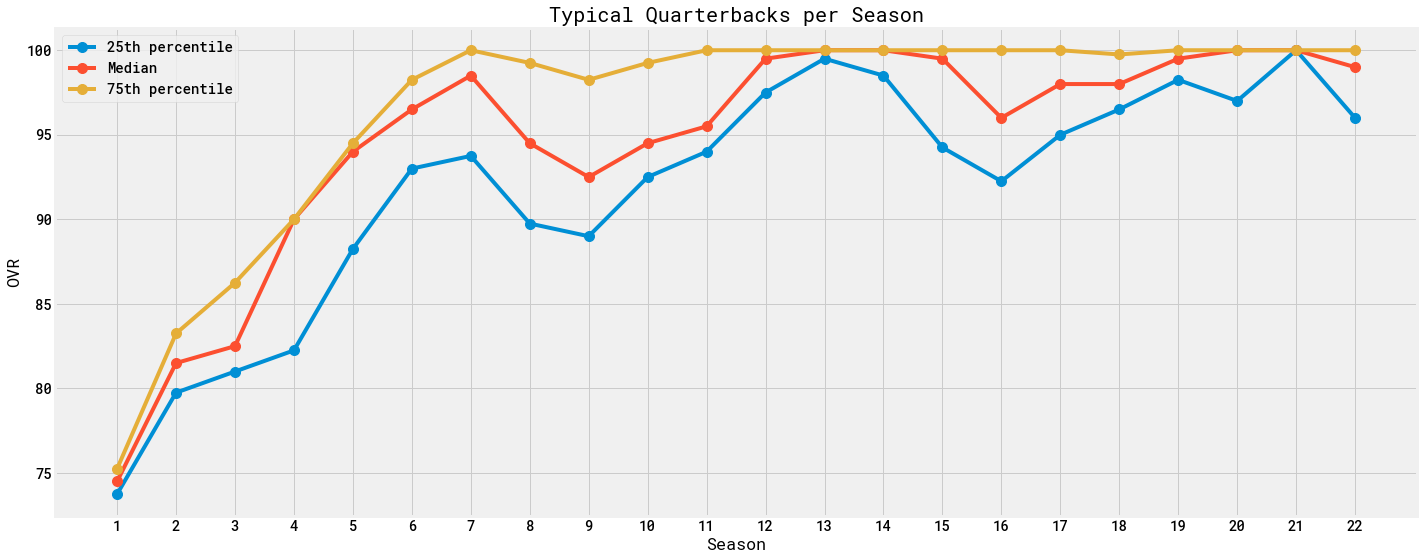

In [16]:
passOVRlist75 = [passDF[passDF.S == i]['OVR'].describe().loc['75%'] for i in range(1,23)]
passOVRlist50 = [passDF[passDF.S == i]['OVR'].describe().loc['50%'] for i in range(1,23)]
passOVRlist25 = [passDF[passDF.S == i]['OVR'].describe().loc['25%'] for i in range(1,23)]

plt.figure(figsize=(20,8),facecolor='w')
plt.title('Typical Quarterbacks per Season')
plt.ylabel('OVR')
plt.xlabel('Season')
plt.xticks(range(1,23))
# plt.plot(range(1,23),recOVRlistAVG,marker='o',markersize=10,label='Mean')
plt.plot(range(1,23),passOVRlist25,marker='o',markersize=10,label='25th percentile')
plt.plot(range(1,23),passOVRlist50,marker='o',markersize=10,label='Median')
plt.plot(range(1,23),passOVRlist75,marker='o',markersize=10,label='75th percentile')
plt.legend()
plt.tight_layout()
plt.savefig('passing/QBs.png')
plt.show()

What we see here is that the very best QBs are 100 OVR pretty consistently after S6. There has been *some* archetype switching recently (S21 on), but the main arch has always been Pocket Passer. So clearly it's not the QBs that are changing.

### Receivers
There's a belief that WRs these days just aren't as good as they used to be - is that true?

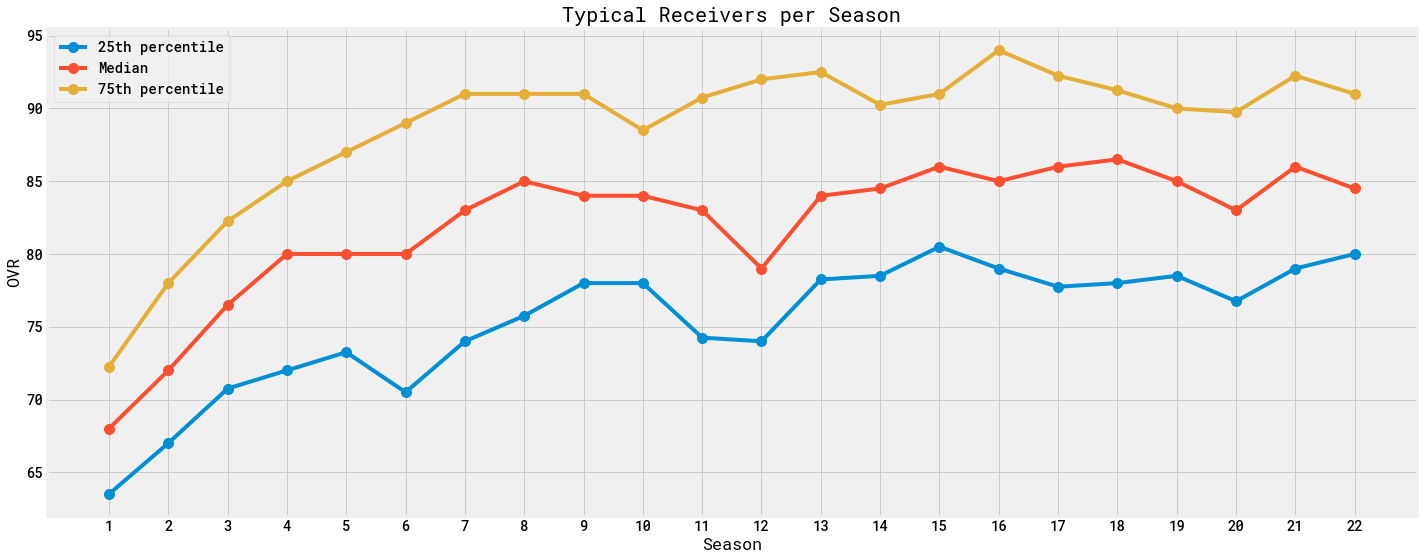

In [17]:
recDF = pd.read_csv('Stats/ReceivingDF.csv')
recDF = recDF[recDF['Pos'] == 'WR']

recOVRlist75 = [recDF[recDF.S == i]['OVR'].describe().loc['75%'] for i in range(1,23)]
recOVRlist50 = [recDF[recDF.S == i]['OVR'].describe().loc['50%'] for i in range(1,23)]
recOVRlist25 = [recDF[recDF.S == i]['OVR'].describe().loc['25%'] for i in range(1,23)]

plt.figure(figsize=(20,8),facecolor='w')
plt.title('Typical Receivers per Season')
plt.ylabel('OVR')
plt.xlabel('Season')
plt.xticks(range(1,23))
# plt.plot(range(1,23),recOVRlistAVG,marker='o',markersize=10,label='Mean')
plt.plot(range(1,23),recOVRlist25,marker='o',markersize=10,label='25th percentile')
plt.plot(range(1,23),recOVRlist50,marker='o',markersize=10,label='Median')
plt.plot(range(1,23),recOVRlist75,marker='o',markersize=10,label='75th percentile')
plt.legend()
plt.tight_layout()
plt.savefig('passing/WRs.png')
plt.show()

If we take the sim's OVR stat (which as we know, sim be dumb sometimes), we see that if anything the WRs of the league have gotten *better* over time. 

### Running Backs


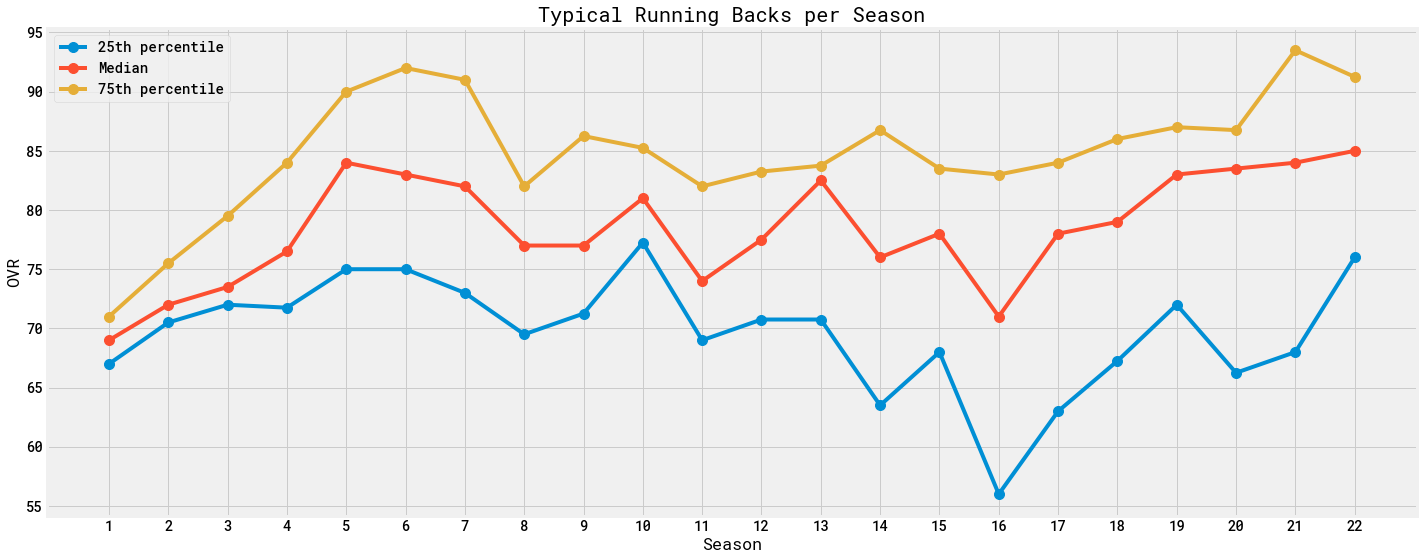

In [18]:
runDF = pd.read_csv('Stats/RushingDF.csv')
runDF = runDF[(runDF.Position == 'RB') | (runDF.Position == 'FB')]
runDF = runDF[runDF['Att'] > 25]

runOVRlist75 = [runDF[runDF.S == i]['OVR'].describe().loc['75%'] for i in range(1,23)]
runOVRlist50 = [runDF[runDF.S == i]['OVR'].describe().loc['50%'] for i in range(1,23)]
runOVRlist25 = [runDF[runDF.S == i]['OVR'].describe().loc['25%'] for i in range(1,23)]

plt.figure(figsize=(20,8),facecolor='w')
plt.title('Typical Running Backs per Season')
plt.ylabel('OVR')
plt.xlabel('Season')
plt.xticks(range(1,23))
# plt.plot(range(1,23),recOVRlistAVG,marker='o',markersize=10,label='Mean')
plt.plot(range(1,23),runOVRlist25,marker='o',markersize=10,label='25th percentile')
plt.plot(range(1,23),runOVRlist50,marker='o',markersize=10,label='Median')
plt.plot(range(1,23),runOVRlist75,marker='o',markersize=10,label='75th percentile')
plt.legend()
plt.tight_layout()
plt.savefig('passing/RBs.png')
plt.show()

Runningbacks have stayed relatively constant over the seasons, though there is a substantial improvement in more recent years. This may lead some teams to run the ball more often than in the past, but I bet there's more to the story.

### Defense

The QB has to go up against the defense, obviously, so has that changed significantly in recent years?

In [19]:
defDF = pd.read_csv('Stats/DefensiveDF.csv')

dbDF = defDF[(defDF['Pos'] == 'CB') | (defDF['Pos'] == 'FS') | (defDF['Pos'] == 'SS')]

dbOVRlist75 = [dbDF[dbDF.S == i]['OVR'].describe().loc['75%'] for i in range(1,23)]
dbOVRlist50 = [dbDF[dbDF.S == i]['OVR'].describe().loc['50%'] for i in range(1,23)]
dbOVRlist25 = [dbDF[dbDF.S == i]['OVR'].describe().loc['25%'] for i in range(1,23)]

lbDF = defDF[(defDF['Pos'] == 'LB')]

lbOVRlist75 = [lbDF[lbDF.S == i]['OVR'].describe().loc['75%'] for i in range(1,23)]
lbOVRlist50 = [lbDF[lbDF.S == i]['OVR'].describe().loc['50%'] for i in range(1,23)]
lbOVRlist25 = [lbDF[lbDF.S == i]['OVR'].describe().loc['25%'] for i in range(1,23)]

dlDF = defDF[(defDF['Pos'] == 'DE') | (defDF['Pos'] == 'DT')]

dlOVRlist75 = [dlDF[dlDF.S == i]['OVR'].describe().loc['75%'] for i in range(1,23)]
dlOVRlist50 = [dlDF[dlDF.S == i]['OVR'].describe().loc['50%'] for i in range(1,23)]
dlOVRlist25 = [dlDF[dlDF.S == i]['OVR'].describe().loc['25%'] for i in range(1,23)]

### Defensive Backs

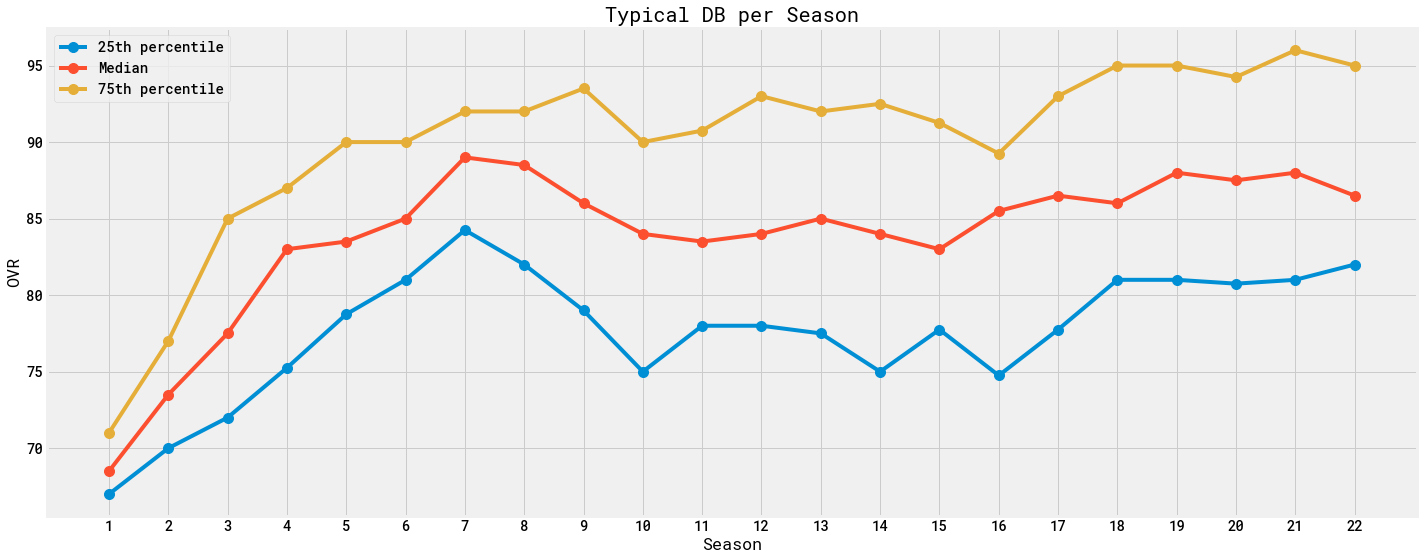

In [20]:
plt.figure(figsize=(20,8),facecolor='w')
plt.title('Typical DB per Season')
plt.ylabel('OVR')
plt.xlabel('Season')
plt.xticks(range(1,23))
# plt.plot(range(1,23),recOVRlistAVG,marker='o',markersize=10,label='Mean')
plt.plot(range(1,23),dbOVRlist25,marker='o',markersize=10,label='25th percentile')
plt.plot(range(1,23),dbOVRlist50,marker='o',markersize=10,label='Median')
plt.plot(range(1,23),dbOVRlist75,marker='o',markersize=10,label='75th percentile')
plt.legend()
plt.tight_layout()
plt.savefig('passing/DBs.png')
plt.show()

I think here we can see the main catalyst for the switch - in S17, DBs across the board improved significantly. This probably forced teams to look to the run to support their offense more, and the improvement in RBs may be a lagging indicator of that.

### Front Seven

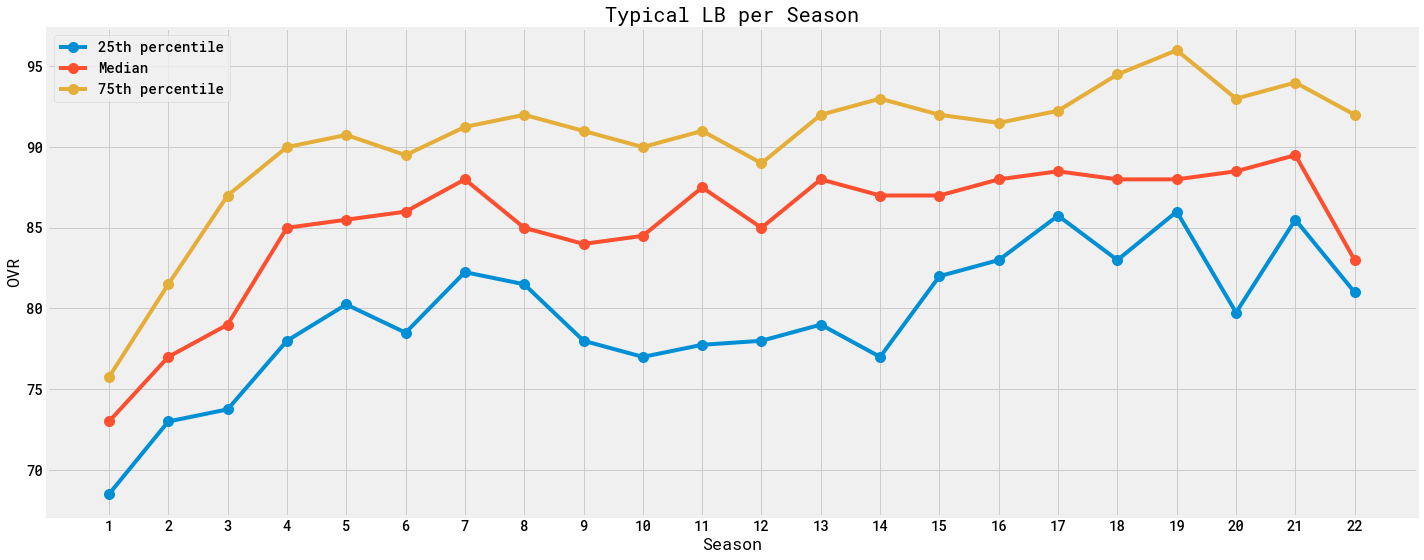

In [21]:
plt.figure(figsize=(20,8),facecolor='w')
plt.title('Typical LB per Season')
plt.ylabel('OVR')
plt.xlabel('Season')
plt.xticks(range(1,23))
# plt.plot(range(1,23),recOVRlistAVG,marker='o',markersize=10,label='Mean')
plt.plot(range(1,23),lbOVRlist25,marker='o',markersize=10,label='25th percentile')
plt.plot(range(1,23),lbOVRlist50,marker='o',markersize=10,label='Median')
plt.plot(range(1,23),lbOVRlist75,marker='o',markersize=10,label='75th percentile')
plt.legend()
plt.tight_layout()
plt.savefig('passing/LBs.png')
plt.show()

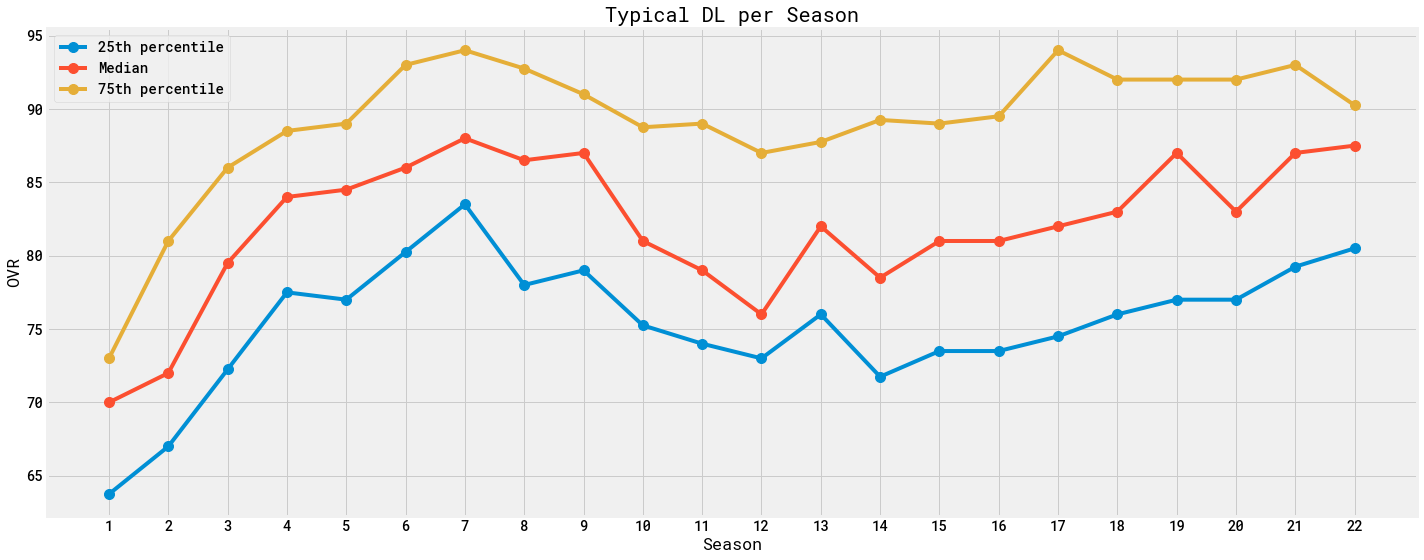

In [22]:
plt.figure(figsize=(20,8),facecolor='w')
plt.title('Typical DL per Season')
plt.ylabel('OVR')
plt.xlabel('Season')
plt.xticks(range(1,23))
# plt.plot(range(1,23),recOVRlistAVG,marker='o',markersize=10,label='Mean')
plt.plot(range(1,23),dlOVRlist25,marker='o',markersize=10,label='25th percentile')
plt.plot(range(1,23),dlOVRlist50,marker='o',markersize=10,label='Median')
plt.plot(range(1,23),dlOVRlist75,marker='o',markersize=10,label='75th percentile')
plt.legend()
plt.tight_layout()
plt.savefig('passing/DLs.png')
plt.show()

The front seven as a whole don't seem to have too much improvement in recent times, though the top tier LBs are improving significantly and the bottom tier DL are improving significantly. Everything else is just slight improvement here.

***
## Conclusions

There's a few things we can conclude from this study:
* Teams are less reliant on their QBs to do all the heavy lifting - instead asking their QBs to play it safe and get the ball downfield with the help of the run game.
* DBs and RBs showed significant improvement, and the improvement in DBs probably increased the need for high TPE RBs
* The strong /r/NFL recruitment drive in S14 changed the dynamics of the league